# 1. Project Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mode


In [ ]:
###### Set display options to show all columns/rows and suppress scientific notation for floats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

# --- Data Loading ---

In [101]:
# Assuming the file is named 'Insurance Data.xlsx' in the current working directory
try:
    data = pd.read_excel(r"C:\Users\Admin\Desktop\DA.BA\Cross_Selling_Project Naresh IT\Insurance_Data_50k.xlsx")

except FileNotFoundError:
    print("Error: Insurance Data.xlsx not found. Please ensure the file is in the correct directory.")


# --- Initial Data Prep ---

In [4]:
# Clean column names (replace spaces with underscores)
data.columns = [re.sub(r'[\s/]+', '_', x.strip()) for x in data.columns]

# Display initial shape and first few rows
print(f"Initial Shape: {data.shape}")
print("First 5 rows of the dataset:")
data.head()


Initial Shape: (50000, 16)
First 5 rows of the dataset:


,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,30.00,F,Divorced,2.00,LHS,SPT,PG,1.95,No,NO,-20709.00,INV,2155940.00,Cold,Converted,Converted
1,48.00,M,Divorced,3.00,LHS,SFT,OC,6.37,No,NO,-52383.00,TLE,991685.00,Warm,Converted,Converted
2,53.00,M,Married,4.00,NE,SPT,PG,5.82,Yes,NO,4018892.00,ANS,1972325.00,Cold,NotConverted,AS
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
4,37.00,M,Married,3.00,BD,SPT,BA,1.17,No,NO,27473.00,TLE,1984786.00,Hot,NotConverted,Converted


# 2. Data Understanding and Missing Values

Let's check for missing values to understand where we need to apply the cleaning strategies.

In [5]:
print("Missing values before cleaning:")
print(data.isnull().sum())

Missing values before cleaning:
Age                     22
Gender                  91
Marital_Status          21
Family_Members          11
Education               23
Occupation              22
Job_Title               62
Income                  49
Current_Product          9
Current_Product_Type    16
Current_Coverage        24
New_Product_Type        24
New_Coverage            64
Rating                  22
Converted               24
Status                   0
dtype: int64


All variables except Status have missing values, but the report indicates specific strategies for most of them.

## Data Engineering Strategy (from provided document)

We will implement the imputation based on the following general strategy:
1. **Simple Imputation (Mean/Median/Mode):** For most standalone variables.
2. **Complex Imputation (Group-wise Mean/Median/Mode):** For Income, Current_Coverage, and New_Coverage.
3. **Conditional Imputation (Business Logic):** For Current_Product, Current_Product_Type, Current_Coverage.
4. **Target Variable:** Drop missing Converted rows.
5. **Feature Selection:** Drop Gender and Marital_Status (as in the code snippet).

# 3. Data Cleaning and Preprocessing

## Handling Simple Missing Values (Age, Family_Members, Categorical)

### Age

Strategy: Calculate Mean and Median, Choose the lowest value (which is 39.0)

In [6]:
age_mean = data['Age'].mean()
age_median = data['Age'].median()
print(age_mean, age_median)

38.97957101124495 39.0


In [7]:
replacement = age_mean if age_mean < age_median else age_median
replacement

np.float64(38.97957101124495)

In [8]:
data['Age'].fillna(replacement, inplace=True)
print(f"Age missing values filled with median: {age_median}")

Age missing values filled with median: 39.0


In [9]:
data['Age'].isnull().sum()

np.int64(0)

### Family_Members

Missing Values were imputed by considering the minimum value between the mean
and median values which were calculated excluding the missing data

In [10]:
fm_mean = data['Family_Members'].mean()
fm_median = data['Family_Members'].median()
print(fm_mean, fm_median)
replacement = fm_mean if fm_mean < fm_median else fm_median
replacement

4.658804937086159 4.0


4.0

In [11]:
print("The value used fo replacement", replacement)
data['Family_Members'].fillna(replacement, inplace=True)

print(f"Family_Members missing values filled with median: {replacement}")

The value used fo replacement 4.0
Family_Members missing values filled with median: 4.0


In [12]:
data.dtypes

Age                     float64
Gender                   object
Marital_Status           object
Family_Members          float64
Education                object
Occupation               object
Job_Title                object
Income                  float64
Current_Product          object
Current_Product_Type     object
Current_Coverage        float64
New_Product_Type         object
New_Coverage            float64
Rating                   object
Converted                object
Status                   object
dtype: object

### Education, Occupation, Job_Title, New_Product_Type, Rating: Replace with Mode

In [13]:
categorical_cols = ['Education', 'Occupation', 'Job_Title', 'New_Product_Type', 'Rating']
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)
    print(f"Variable {col} missing values filled with mode: {data[col].mode()[0]}")

Variable Education missing values filled with mode: BD
Variable Occupation missing values filled with mode: SPT
Variable Job_Title missing values filled with mode: FH
Variable New_Product_Type missing values filled with mode: ANS
Variable Rating missing values filled with mode: Cold


## Handling Income Missing Values (Grouped Mean/Median)

In [14]:
# Get mean and median grouped by Occupation
income_mean = data.groupby('Occupation')['Income'].mean()
income_median = data.groupby('Occupation')['Income'].median()

In [15]:
income_mean

Occupation
SE    4.94
SFT   4.92
SPT   4.99
Name: Income, dtype: float64

In [16]:
income_median

Occupation
SE    3.02
SFT   3.01
SPT   3.06
Name: Income, dtype: float64

In [ ]:
# for occ, mean in income_mean.items():
#     print(occ)
#     print(mean)
#     break

In [ ]:
# income_median['SFT']

In [ ]:
# c1 = (data['Occupation'] == 'SE') & data['Income'].isna()
# data[c1]

In [ ]:
# data.loc[c1, 'Income']

In [17]:
# Apply imputation logic
for occ, mean in income_mean.items():
    median = income_median[occ]

    # Choose the smaller of mean or median
    imputation_value = min(mean, median)

    # Find rows where Occupation matches and Income is missing
    mask = (data['Occupation'] == occ) & (data['Income'].isna())

    # Fill missing values
    data.loc[mask, 'Income'] = imputation_value

    print(f"Occupation: {occ}, Mean: {mean:.2f}, Median: {median:.2f}, Imputed with: {imputation_value:.2f}")

print(f"\nIncome missing values left: {data['Income'].isna().sum()}")

Occupation: SE, Mean: 4.94, Median: 3.02, Imputed with: 3.02
Occupation: SFT, Mean: 4.92, Median: 3.01, Imputed with: 3.01
Occupation: SPT, Mean: 4.99, Median: 3.06, Imputed with: 3.06

Income missing values left: 0


In [18]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,30.00,F,Divorced,2.00,LHS,SPT,PG,1.95,No,NO,-20709.00,INV,2155940.00,Cold,Converted,Converted
1,48.00,M,Divorced,3.00,LHS,SFT,OC,6.37,No,NO,-52383.00,TLE,991685.00,Warm,Converted,Converted
2,53.00,M,Married,4.00,NE,SPT,PG,5.82,Yes,NO,4018892.00,ANS,1972325.00,Cold,NotConverted,AS
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
4,37.00,M,Married,3.00,BD,SPT,BA,1.17,No,NO,27473.00,TLE,1984786.00,Hot,NotConverted,Converted


## Handling Interdependent Missing Values (Current Product, Type, Coverage)

This is a multi-step process requiring careful application of business logic.

### Step 1: Impute Current_Product (Yes/No)

**Strategy (from report):** If Current_Product_Type is 'NA' or Current_Coverage is 0, then Current_Product is 'No'. Otherwise, 'Yes'.

Note: Since we are filling in order, Current_Product_Type and Current_Coverage may still have missing values (NaN) at this stage.

#### Step 1: Impute Current_Product

In [19]:
c1 = data['Current_Product'].isna()
data[c1]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
3057,34.00,M,Married,2.00,BD,SPT,CB,9.27,NaN,NO,46806.00,ANS,2933667.00,Warm,Converted,Converted
4687,42.00,F,Married,2.00,MD,SPT,FH,9.35,NaN,NO,68337.00,ANS,2996273.00,Cold,Converted,Converted
6151,28.00,F,Married,7.00,UHS,SPT,FH,4.80,NaN,NO,984326.00,ANS,2967208.00,Hot,Converted,NW
18058,44.00,M,Married,9.00,BD,SE,OT,2.03,NaN,PMT,106040.00,ANS,15028047.00,Cold,NotConverted,QG
20282,34.00,F,Married,10.00,PD,SPT,FH,9.29,NaN,END,60401.00,END,4989096.00,Cold,NotConverted,AS
22396,56.00,F,Married,7.00,LHS,SPT,PG,3.53,NaN,PMT,-30483.00,ANS,2032073.00,Cold,NotConverted,PW
23094,39.00,F,Divorced,1.00,LHS,SE,PR,7.92,NaN,NO,3017127.00,INV,1057781.00,Hot,NotConverted,Converted
44320,22.00,M,Married,4.00,NE,SPT,FH,1.94,NaN,TLE,2936075.00,ANS,4081902.00,Cold,Converted,PN
46676,28.00,F,Divorced,4.00,BD,SPT,DD,6.53,NaN,ANS,-12088.00,ANS,1985458.00,Warm,NotConverted,QG


In [20]:
data[c1].index

Index([3057, 4687, 6151, 18058, 20282, 22396, 23094, 44320, 46676], dtype='int64')

In [21]:
# Identify rows where Current_Product is missing (NaN)
missing_prod_idx = data[data['Current_Product'].isna()].index
missing_prod_idx

Index([3057, 4687, 6151, 18058, 20282, 22396, 23094, 44320, 46676], dtype='int64')

In [22]:
c1 = (data.loc[missing_prod_idx, 'Current_Product_Type'] == 'NO')

c2 = (data.loc[missing_prod_idx, 'Current_Coverage'] == 0.0)



In [23]:
data.loc[missing_prod_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
3057,34.00,M,Married,2.00,BD,SPT,CB,9.27,NaN,NO,46806.00,ANS,2933667.00,Warm,Converted,Converted
4687,42.00,F,Married,2.00,MD,SPT,FH,9.35,NaN,NO,68337.00,ANS,2996273.00,Cold,Converted,Converted
6151,28.00,F,Married,7.00,UHS,SPT,FH,4.80,NaN,NO,984326.00,ANS,2967208.00,Hot,Converted,NW
23094,39.00,F,Divorced,1.00,LHS,SE,PR,7.92,NaN,NO,3017127.00,INV,1057781.00,Hot,NotConverted,Converted


In [24]:
data.loc[missing_prod_idx][c1 | c2].index

Index([3057, 4687, 6151, 23094], dtype='int64')

In [25]:
# --- Scenario 1: No product ---
# If CPT is 'NA' OR CC is 0.0 (or both are missing) -> No
# Note: We assume missing CPT and CC for a missing CP indicates 'No' since they are related
# and 'NO' is the majority class in the full data for CPT.
idx_no = data.loc[missing_prod_idx][(data.loc[missing_prod_idx, 'Current_Product_Type'] == 'NO') | (data.loc[missing_prod_idx, 'Current_Coverage'] == 0.0)].index
data.loc[idx_no, 'Current_Product'] = 'No'

In [26]:
# cross check
data.loc[missing_prod_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
3057,34.00,M,Married,2.00,BD,SPT,CB,9.27,No,NO,46806.00,ANS,2933667.00,Warm,Converted,Converted
4687,42.00,F,Married,2.00,MD,SPT,FH,9.35,No,NO,68337.00,ANS,2996273.00,Cold,Converted,Converted
6151,28.00,F,Married,7.00,UHS,SPT,FH,4.80,No,NO,984326.00,ANS,2967208.00,Hot,Converted,NW
23094,39.00,F,Divorced,1.00,LHS,SE,PR,7.92,No,NO,3017127.00,INV,1057781.00,Hot,NotConverted,Converted


In [27]:
data['Current_Product'].isnull().sum()

np.int64(5)

In [28]:
# --- Scenario 2: Existing customer (Yes) ---
# If CP is still missing after above step -> Yes (implying non-NA type and non-zero coverage, even if those are NaN)
data['Current_Product'].fillna('Yes', inplace=True)

print(f"Current_Product missing values handled. New counts: \n{data['Current_Product'].value_counts()}")

Current_Product missing values handled. New counts: 
Current_Product
Yes    28442
No     21558
Name: count, dtype: int64


In [29]:
data['Current_Product'].isnull().sum()

np.int64(0)

#### Step 2: Impute Current_Product_Type
*   **Strategy (from report):** If `Current_Product` is 'No' or `Current_Coverage` is 0, then `Current_Product_Type` is 'NA' (using 'NO' as per the data). Otherwise, fill with Mode ('ANS').


In [ ]:
# Step 2: Impute Current_Product_Type

In [ ]:
# let me create a datarame of missing values
# c1 = data['Current_Product_Type'].isna()
# cpt_missing_idx = data[c1].index

In [30]:
# Identify rows where Current_Product_Type is missing (NaN)
product_type_col = 'Current_Product_Type'

missing_cpt_idx = data[data[product_type_col].isna()].index
missing_cpt_idx

Index([  542,   605,  1977,  2037,  3051,  6986,  8947,  9268, 11706, 15549,
       16402, 20439, 26622, 34146, 36138, 44087],
      dtype='int64')

In [31]:
c1 = data['Current_Product'] == 'NO'
c2 = data['Current_Coverage'] == 0.0

In [32]:
data.loc[missing_cpt_idx]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
542,57.00,F,Single,4.00,BD,SE,PG,9.48,Yes,NaN,15088033.00,ANS,15001049.00,Warm,Converted,ARS
605,26.00,F,Married,9.00,PD,SPT,FH,1.60,Yes,NaN,1984585.00,ANS,14899846.00,Cold,Converted,NW
1977,18.00,F,Single,5.00,NE,SE,FH,1.49,Yes,NaN,46075.00,TLE,4086659.00,Warm,NotConverted,NW
2037,37.00,F,Single,10.00,MD,SE,OM,1.15,Yes,NaN,-59423.00,INV,14989910.00,Hot,NotConverted,Converted
3051,24.00,F,Married,10.00,BD,SE,OT,10.02,Yes,NaN,3052414.00,TLE,2973748.00,Hot,NotConverted,Converted
6986,30.00,M,Married,2.00,LHS,SE,PG,9.44,Yes,NaN,14987708.00,TLE,1018979.00,Warm,NotConverted,AS
8947,21.00,F,Single,2.00,BD,SE,FH,9.89,No,NaN,-27264.00,ANS,3984153.00,Cold,NotConverted,Converted
9268,49.00,M,Divorced,1.00,MD,SPT,DD,1.07,No,NaN,929132.00,TLE,973267.00,Hot,Converted,AS
11706,48.00,F,Married,7.00,MD,SE,FH,4.31,Yes,NaN,15011187.00,ANS,14981939.00,Cold,Converted,Converted
15549,32.00,F,Divorced,3.00,NE,SE,PG,7.21,No,NaN,-2248.00,ANS,1976874.00,Hot,Converted,PW


In [33]:
data.loc[missing_cpt_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status


In [34]:
data.loc[missing_cpt_idx][c1 | c2].index

Index([], dtype='int64')

In [36]:
idx_no_type = data.loc[missing_cpt_idx][c1 | c2].index

In [37]:
data.loc[idx_no_type, 'Current_Product_Type']

Series([], Name: Current_Product_Type, dtype: object)

In [38]:
# --- Scenario 1: No product -> 'NO' ---
# If Current_Product is 'No' OR Current_Coverage is 0.0
idx_no_type = data.loc[missing_cpt_idx][(data.loc[missing_cpt_idx, 'Current_Product'] == 'No') | (data.loc[missing_cpt_idx, 'Current_Coverage'] == 0.0)].index
data.loc[idx_no_type, product_type_col] = 'NO'

In [39]:
# cross check
data.loc[missing_cpt_idx][c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status


In [40]:
data['Current_Product_Type'].isnull().sum()

np.int64(10)

In [41]:
# --- Scenario 2: Existing customer -> Mode ---
# If CPT is still missing, fill with the mode of the *non-NO* types ('ANS' in the example)
remaining_missing_idx = data[data[product_type_col].isna()].index
remaining_missing_idx

Index([542, 605, 1977, 2037, 3051, 6986, 11706, 20439, 36138, 44087], dtype='int64')

In [42]:
data.loc[remaining_missing_idx]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
542,57.00,F,Single,4.00,BD,SE,PG,9.48,Yes,NaN,15088033.00,ANS,15001049.00,Warm,Converted,ARS
605,26.00,F,Married,9.00,PD,SPT,FH,1.60,Yes,NaN,1984585.00,ANS,14899846.00,Cold,Converted,NW
1977,18.00,F,Single,5.00,NE,SE,FH,1.49,Yes,NaN,46075.00,TLE,4086659.00,Warm,NotConverted,NW
2037,37.00,F,Single,10.00,MD,SE,OM,1.15,Yes,NaN,-59423.00,INV,14989910.00,Hot,NotConverted,Converted
3051,24.00,F,Married,10.00,BD,SE,OT,10.02,Yes,NaN,3052414.00,TLE,2973748.00,Hot,NotConverted,Converted
6986,30.00,M,Married,2.00,LHS,SE,PG,9.44,Yes,NaN,14987708.00,TLE,1018979.00,Warm,NotConverted,AS
11706,48.00,F,Married,7.00,MD,SE,FH,4.31,Yes,NaN,15011187.00,ANS,14981939.00,Cold,Converted,Converted
20439,41.00,M,Divorced,2.00,LHS,SE,PG,2.01,Yes,NaN,25045.00,INV,1038962.00,Cold,NotConverted,Converted
36138,44.00,F,Single,2.00,UHS,SE,FH,5.87,Yes,NaN,15050706.00,ANS,1022276.00,Hot,NotConverted,Converted
44087,21.00,F,Married,1.00,BD,SFT,DD,2.25,Yes,NaN,2037604.00,PMT,4061090.00,Cold,NotConverted,PW


In [ ]:
# non_no_data.empty

In [ ]:
# non_no_data = data[data[product_type_col] != 'NO'][product_type_col].dropna()
# mode_non_no = non_no_data.mode()[0] if not non_no_data.empty else 'ANS'
# mode_non_no

In [ ]:
# # Calculate mode of non-NO types
# non_no_data = data[data[product_type_col] != 'NO'][product_type_col].dropna()
# mode_non_no = non_no_data.mode()[0] if not non_no_data.empty else 'ANS' # Use ANS as default

# data.loc[remaining_missing_idx, product_type_col] = mode_non_no

# print(f"Current_Product_Type missing values handled. New counts: \n{data[product_type_col].value_counts()}")

In [43]:
data['Current_Product_Type'].mode()[0] # from this we could see most of the customers are new customers 

'NO'

To get the proper mode value we need to elimkinate the new customers from the data

As we know, where the cusrrent product type is 'NO', which means they are new customers

In [44]:
c1 = data['Current_Product_Type'] != 'NO'

data[c1].head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
6,58.00,F,Married,2.00,LHS,SE,RR,8.98,Yes,INV,19557.00,END,985299.00,Hot,NotConverted,PS
7,49.00,F,Divorced,7.00,LHS,SE,PG,9.53,No,PMT,59030.00,END,1022635.00,Cold,NotConverted,Converted
8,40.00,F,Married,6.00,PD,SPT,FH,1.47,Yes,ANS,15004736.00,TLE,2946612.00,Hot,Converted,PS
10,33.00,F,Married,5.00,UHS,SE,BA,2.28,Yes,END,2073883.00,ANS,14965529.00,Warm,NotConverted,NW


In [45]:
existing_customers = data[c1]

In [46]:
existing_customers['Current_Product_Type'].mode()

0    ANS
Name: Current_Product_Type, dtype: object

In [47]:
existing_customers['Current_Product_Type'].mode()[0]

'ANS'

In [48]:
data['Current_Product_Type'].fillna(existing_customers['Current_Product_Type'].mode()[0], inplace =  True)

In [ ]:
# data['Current_Product_Type'].fillna(data[(data['Current_Product_Type'] != 'NO')]['Current_Product_Type'].mode()[0], inplace =  True)

In [49]:
# lets cross chechk the missing values
data['Current_Product_Type'].isnull().sum()

np.int64(0)

In [50]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,30.00,F,Divorced,2.00,LHS,SPT,PG,1.95,No,NO,-20709.00,INV,2155940.00,Cold,Converted,Converted
1,48.00,M,Divorced,3.00,LHS,SFT,OC,6.37,No,NO,-52383.00,TLE,991685.00,Warm,Converted,Converted
2,53.00,M,Married,4.00,NE,SPT,PG,5.82,Yes,NO,4018892.00,ANS,1972325.00,Cold,NotConverted,AS
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
4,37.00,M,Married,3.00,BD,SPT,BA,1.17,No,NO,27473.00,TLE,1984786.00,Hot,NotConverted,Converted


In [ ]:
c1a = (data['Current_Coverage'].isna())
c1b = ((data['Current_Product'] == 'No'))

c2 = (data['Current_Product_Type'] == 'NO'))
       

#### Step 3: Impute Current_Coverage

*   **Strategy (from report):** If `Current_Product` is 'No' or `Current_Product_Type` is 'NA' (NO), then `Current_Coverage` is 0. Otherwise, calculate Mean/Median for the `Current_Product_Type` and fill with the lowest of the two.


In [ ]:
# c1 = data['Current_Coverage'].isnull()
# data[c1]

In [52]:
c1 = data['Current_Coverage'].isnull()
coverage_missing_idx = data[c1].index
# we have collected the row indexes whetre we have the missing values  in 'Current_Coverage'

In [53]:
# now will create a df with only missing values
coverage_missing_df = data.loc[coverage_missing_idx]

In [54]:
coverage_missing_df.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
533,58.00,M,Married,7.00,BD,SPT,PR,6.94,No,NO,NaN,TLE,979835.00,Cold,Converted,QG
937,51.00,F,Divorced,8.00,BD,SPT,PG,1.49,No,ANS,NaN,INV,14975006.00,Cold,Converted,PW
5288,55.00,F,Married,9.00,LHS,SE,FH,2.89,Yes,NO,NaN,PMT,1092594.00,Cold,NotConverted,Converted
12729,56.00,M,Single,2.00,UHS,SPT,PR,2.24,No,NO,NaN,ANS,2937499.00,Warm,NotConverted,ARS
12789,33.00,F,Married,5.00,MD,SPT,FH,9.05,Yes,NO,NaN,PMT,1024521.00,Hot,NotConverted,NW


In [55]:
# Now I want to check the where I have current product is 'No' or Current_Product_Type is 'NO'
c1 = (coverage_missing_df['Current_Product'] == 'No')
c2 = (coverage_missing_df['Current_Product_Type'] == 'NO')

coverage_missing_df[c1 | c2]

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
533,58.00,M,Married,7.00,BD,SPT,PR,6.94,No,NO,NaN,TLE,979835.00,Cold,Converted,QG
937,51.00,F,Divorced,8.00,BD,SPT,PG,1.49,No,ANS,NaN,INV,14975006.00,Cold,Converted,PW
5288,55.00,F,Married,9.00,LHS,SE,FH,2.89,Yes,NO,NaN,PMT,1092594.00,Cold,NotConverted,Converted
12729,56.00,M,Single,2.00,UHS,SPT,PR,2.24,No,NO,NaN,ANS,2937499.00,Warm,NotConverted,ARS
12789,33.00,F,Married,5.00,MD,SPT,FH,9.05,Yes,NO,NaN,PMT,1024521.00,Hot,NotConverted,NW
14781,24.00,M,Married,6.00,BD,SE,BA,1.25,No,PMT,NaN,TLE,1949558.00,Cold,NotConverted,PW
17876,57.00,M,Married,1.00,BD,SE,BA,9.78,No,NO,NaN,END,2077372.00,Warm,Converted,ARS
18632,18.00,F,Married,9.00,BD,SPT,PR,9.30,No,END,NaN,INV,1996759.00,Cold,Converted,PS
19063,45.00,M,Single,1.00,BD,SFT,PG,4.78,Yes,NO,NaN,TLE,14971228.00,Warm,Converted,AS
19728,44.00,M,Single,3.00,NE,SFT,RR,2.11,No,ANS,NaN,TLE,15064654.00,Warm,NotConverted,PP


In [56]:
coverage_missing_df[c1 | c2].index

Index([  533,   937,  5288, 12729, 12789, 14781, 17876, 18632, 19063, 19728,
       21587, 26193, 32795, 36326, 45842, 49595, 49812],
      dtype='int64')

In [57]:
# Step 3: Impute Current_Coverage
coverage_col = 'Current_Coverage'

# --- Scenario 1: No product -> 0 ---
# If Current_Product is 'No' OR Current_Product_Type is 'NO'
index_zero = data[(data[coverage_col].isna()) & ((data['Current_Product'] == 'No') | (data['Current_Product_Type'] == 'NO'))].index
index_zero

Index([  533,   937,  5288, 12729, 12789, 14781, 17876, 18632, 19063, 19728,
       21587, 26193, 32795, 36326, 45842, 49595, 49812],
      dtype='int64')

In [58]:
data.loc[index_zero, 'Current_Coverage']

533     NaN
937     NaN
5288    NaN
12729   NaN
12789   NaN
14781   NaN
17876   NaN
18632   NaN
19063   NaN
19728   NaN
21587   NaN
26193   NaN
32795   NaN
36326   NaN
45842   NaN
49595   NaN
49812   NaN
Name: Current_Coverage, dtype: float64

In [59]:
data.loc[index_zero, coverage_col] = 0.0

print(f"Current_Coverage missing values filled with 0 for 'No' cases: {index_zero.shape[0]}")

Current_Coverage missing values filled with 0 for 'No' cases: 17


In [60]:
# now let check for the number of missing values in 'Current_Coverage'
data['Current_Coverage'].isnull().sum()

np.int64(7)

In [61]:
# step 1:
remaining_missing_idx = data[data[coverage_col].isna()].index
remaining_missing_idx

Index([15757, 21488, 32712, 40787, 40990, 44788, 48819], dtype='int64')

In [62]:
# step 2:
non_no_data = data[data['Current_Product_Type'] != 'NO']
non_no_data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
6,58.00,F,Married,2.00,LHS,SE,RR,8.98,Yes,INV,19557.00,END,985299.00,Hot,NotConverted,PS
7,49.00,F,Divorced,7.00,LHS,SE,PG,9.53,No,PMT,59030.00,END,1022635.00,Cold,NotConverted,Converted
8,40.00,F,Married,6.00,PD,SPT,FH,1.47,Yes,ANS,15004736.00,TLE,2946612.00,Hot,Converted,PS
10,33.00,F,Married,5.00,UHS,SE,BA,2.28,Yes,END,2073883.00,ANS,14965529.00,Warm,NotConverted,NW


In [63]:
# step 3a: we need find the grouped mean, median for 'Current_Coverage' by 'Current_Product_Type'
coverage_mean = non_no_data.groupby('Current_Product_Type')['Current_Coverage'].mean()
coverage_mean

Current_Product_Type
ANS   3625354.20
END   3487457.42
INV   3720713.47
PMT   3591767.70
TLE   3646926.78
Name: Current_Coverage, dtype: float64

In [64]:
# step 3b:
coverage_median = non_no_data.groupby('Current_Product_Type')['Current_Coverage'].median()
coverage_median

Current_Product_Type
ANS   219070.00
END   118102.00
INV   924237.50
PMT   119062.00
TLE   911684.50
Name: Current_Coverage, dtype: float64

In [65]:
# step 4:
for ptype, mean_val in coverage_mean.items():
    print(ptype)
    print(mean_val)
    # median_val = grp_median[ptype]
    break

ANS
3625354.1980208787


In [66]:
# --- Scenario 2: Existing customers -> Grouped Mean/Median ---
remaining_missing_idx = data[data[coverage_col].isna()].index

if not remaining_missing_idx.empty:
    # Calculate group mean/median for non-NO types
    non_no_data = data[data['Current_Product_Type'] != 'NO']

    # Calculate mean and median for the remaining non-NO groups
    grp_mean = non_no_data.groupby('Current_Product_Type')[coverage_col].mean()
    grp_median = non_no_data.groupby('Current_Product_Type')[coverage_col].median()

    for ptype, mean_val in grp_mean.items():
        median_val = grp_median[ptype]
        imputation_value = min(mean_val, median_val)

        # Find rows where coverage is missing and matches the product type
        mask = (data[coverage_col].isna()) & (data['Current_Product_Type'] == ptype)

        # Fill missing values
        data.loc[mask, coverage_col] = imputation_value
        print(f"Current_Coverage missing values filled for {ptype}: {imputation_value:.1f}")

print(f"Current_Coverage remaining NaNs: {data[coverage_col].isna().sum()}")

Current_Coverage missing values filled for ANS: 219070.0
Current_Coverage missing values filled for END: 118102.0
Current_Coverage missing values filled for INV: 924237.5
Current_Coverage missing values filled for PMT: 119062.0
Current_Coverage missing values filled for TLE: 911684.5
Current_Coverage remaining NaNs: 0


In [67]:
# crosds check 
data['Current_Coverage'].isnull().sum()

np.int64(0)

### 3.4. Handling `New_Coverage` Missing Values

Strategy: Group by `New_Product_Type`, calculate mean and median of `New_Coverage`, and fill missing values with the lower of the two for that group.

In [68]:
# New_Product_Type missing values were filled with 'ANS' in step 3.1
coverage_col = 'New_Coverage'
product_type_col = 'New_Product_Type'


In [69]:
# Calculate group mean/median
grp_mean = data.groupby(product_type_col)[coverage_col].mean()
grp_median = data.groupby(product_type_col)[coverage_col].median()

In [70]:
grp_mean

New_Product_Type
ANS   6066023.68
END   6146315.70
INV   6147366.88
PMT   5976171.40
TLE   6110191.54
Name: New_Coverage, dtype: float64

In [71]:
grp_median

New_Product_Type
ANS   2990033.00
END   2986221.50
INV   2992629.50
PMT   2973743.00
TLE   2984015.00
Name: New_Coverage, dtype: float64

In [72]:
# Apply imputation logic
for ptype, mean_val in grp_mean.items():
    median_val = grp_median[ptype]

    # Choose the smaller of mean or median
    imputation_value = min(mean_val, median_val)

    # Find rows where New_Coverage is missing and matches the product type
    mask = (data[coverage_col].isna()) & (data[product_type_col] == ptype)

    # Fill missing values
    data.loc[mask, coverage_col] = imputation_value

    print(f"New_Coverage missing values filled for {ptype}: {imputation_value:.1f}")

print(f"\nNew_Coverage remaining NaNs: {data[coverage_col].isna().sum()}")

New_Coverage missing values filled for ANS: 2990033.0
New_Coverage missing values filled for END: 2986221.5
New_Coverage missing values filled for INV: 2992629.5
New_Coverage missing values filled for PMT: 2973743.0
New_Coverage missing values filled for TLE: 2984015.0

New_Coverage remaining NaNs: 0


In [73]:
# cross check
data['New_Coverage'].isnull().sum()

np.int64(0)

# Handling Other Missing Values and Dropping Columns

In [74]:
data.isnull().sum()

Age                      0
Gender                  91
Marital_Status          21
Family_Members           0
Education                0
Occupation               0
Job_Title                0
Income                   0
Current_Product          0
Current_Product_Type     0
Current_Coverage         0
New_Product_Type         0
New_Coverage             0
Rating                   0
Converted               24
Status                   0
dtype: int64

### Handling Remaining Missing Values (Gender, Marital_Status)
The strategy for these variables is just to impute them with the Mode, which we will do now.

In [75]:
# Impute Gender and Marital_Status with Mode
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Marital_Status'].fillna(data['Marital_Status'].mode()[0], inplace=True)

print("Remaining categorical values imputed with Mode.")

Remaining categorical values imputed with Mode.


In [76]:
data.isnull().sum()

Age                      0
Gender                   0
Marital_Status           0
Family_Members           0
Education                0
Occupation               0
Job_Title                0
Income                   0
Current_Product          0
Current_Product_Type     0
Current_Coverage         0
New_Product_Type         0
New_Coverage             0
Rating                   0
Converted               24
Status                   0
dtype: int64

In [77]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted,Status
0,30.00,F,Divorced,2.00,LHS,SPT,PG,1.95,No,NO,-20709.00,INV,2155940.00,Cold,Converted,Converted
1,48.00,M,Divorced,3.00,LHS,SFT,OC,6.37,No,NO,-52383.00,TLE,991685.00,Warm,Converted,Converted
2,53.00,M,Married,4.00,NE,SPT,PG,5.82,Yes,NO,4018892.00,ANS,1972325.00,Cold,NotConverted,AS
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,NotConverted,Converted
4,37.00,M,Married,3.00,BD,SPT,BA,1.17,No,NO,27473.00,TLE,1984786.00,Hot,NotConverted,Converted


## Handling Target Variable Converted


building a predictive model for the missing values. Since we are doing exploratory analysis now, and Converted is the target, we will drop the rows with missing values to ensure a clean target variable for any later modeling/analysis.

In [78]:
# Drop rows where 'Converted' is missing
data.dropna(subset=['Converted'], inplace=True)
print(f"Dropped rows with missing 'Converted'. New shape: {data.shape}")

Dropped rows with missing 'Converted'. New shape: (49976, 16)


### Dropping Columns

Let's just drop the redundant Status column, which is an exact duplicate of Converted (Converted/NotConverted in both).

In [79]:
# Drop Status column as it's a duplicate of Converted
data.drop('Status', axis=1, inplace=True)
print("Dropped 'Status' column.")

Dropped 'Status' column.


In [80]:
data.shape

(49976, 15)

### Final Check for Missing Values

In [81]:
print("Missing values after Data Cleaning:")
print(data.isnull().sum())
print(f"Data shape after cleaning: {data.shape}")

Missing values after Data Cleaning:
Age                     0
Gender                  0
Marital_Status          0
Family_Members          0
Education               0
Occupation              0
Job_Title               0
Income                  0
Current_Product         0
Current_Product_Type    0
Current_Coverage        0
New_Product_Type        0
New_Coverage            0
Rating                  0
Converted               0
dtype: int64
Data shape after cleaning: (49976, 15)


In [82]:
data['Converted'].head()

0       Converted
1       Converted
2    NotConverted
3    NotConverted
4    NotConverted
Name: Converted, dtype: object

In [83]:
data['Converted'].apply(lambda x: 1 if x == 'Converted' else 0).head()

0    1
1    1
2    0
3    0
4    0
Name: Converted, dtype: int64

In [84]:
# 1. Convert Target Variable 'Converted' to numeric
data['target'] = data['Converted'].apply(lambda x: 1 if x == 'Converted' else 0)
data.drop('Converted', axis=1, inplace=True)

# # 2. Convert remaining object columns to category codes (numerical encoding)
# cat_cols = data.select_dtypes(include='object').columns
# encoding_maps = {}

# for col in cat_cols:
#     data[col] = data[col].astype('category').cat.codes
#     print(f"Encoded '{col}' into numerical codes.")

# # Display the first few rows of the cleaned and encoded data
# print("\nFirst 5 rows of the processed data:")
# print(data.head())
# print(data.dtypes)

In [85]:
data.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,target
0,30.00,F,Divorced,2.00,LHS,SPT,PG,1.95,No,NO,-20709.00,INV,2155940.00,Cold,1
1,48.00,M,Divorced,3.00,LHS,SFT,OC,6.37,No,NO,-52383.00,TLE,991685.00,Warm,1
2,53.00,M,Married,4.00,NE,SPT,PG,5.82,Yes,NO,4018892.00,ANS,1972325.00,Cold,0
3,45.00,M,Married,2.00,PD,SFT,RR,1.23,No,ANS,34644.00,ANS,3932434.00,Warm,0
4,37.00,M,Married,3.00,BD,SPT,BA,1.17,No,NO,27473.00,TLE,1984786.00,Hot,0


In [ ]:
# let me save the cleanewd data
data.to_csv(r"C:\Users\Admin\Desktop\DA.BA\Cross_Selling_Project Naresh IT\cleaned_Insurance_data_50k.csv", index=False)


In [86]:
pip install ydata-profiling

In [ ]:
# import ydata_profiling as pf
from ydata_profiling import ProfileReport 

In [ ]:
profile = ProfileReport(data)
# profile

In [ ]:
profile.to_file(" Naresh IT Insurance_report.html")

In [ ]:
# print(" Univariate Analysis Replication")

# # --- 2.1 Age Distribution () ---
# print("\n--- Age Statistics ---")
# print(f"Average Age of Customers is {data['Age'].mean():.0f} years")

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# fig.suptitle('Age Distribution (Matches Report Page 6)', y=1.02)

# # Box Plot
# sns.boxplot(y=data['Age'], ax=axes[0], color='blue')
# axes[0].set_title('BoxPlot')
# axes[0].set_ylabel('Age')

# # Histogram
# sns.histplot(data['Age'], bins=15, ax=axes[1], color='magenta', kde=False)
# axes[1].set_title('Histogram')
# axes[1].set_xlabel('Age')
# axes[1].set_ylabel('Customer Frequency')
# plt.show()


# # --- 2.2 Gender Distribution () ---
# print("\n--- Gender Distribution ---")
# gender_counts = data['Gender'].value_counts().sort_index()
# print(gender_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Gender', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Gender')
# plt.ylabel('Customer Frequency')
# plt.show()


# # --- 2.3 Marital Status Distribution () ---
# print("\n--- Marital Status Distribution ---")
# marital_counts = data['Marital_Status'].value_counts().sort_index()
# print(marital_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Marital_Status', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Marital Status')
# plt.ylabel('Customer Frequency')
# plt.show()


# # --- 2.4 Education Distribution () ---
# print("\n--- Education Distribution ---")
# edu_counts = data['Education'].value_counts().sort_index()
# print(edu_counts.to_string())

# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='Education', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Education')
# plt.ylabel('Customer Frequency')

# plt.show()


# # --- 2.5 Rating Distribution () ---
# print("\n--- Rating Distribution ---")
# rating_counts = data['Rating'].value_counts().sort_index()
# print(rating_counts.to_string())

# plt.figure(figsize=(6, 5))
# ax = sns.countplot(x='Rating', data=data, color='gray')
# plt.title('Bar Plot: Number of Customers vs Rating')
# plt.ylabel('Customer Frequency')

# plt.show()

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


 Univariate Analysis Replication

--- Age Statistics ---
Average Age of Customers is 39 years


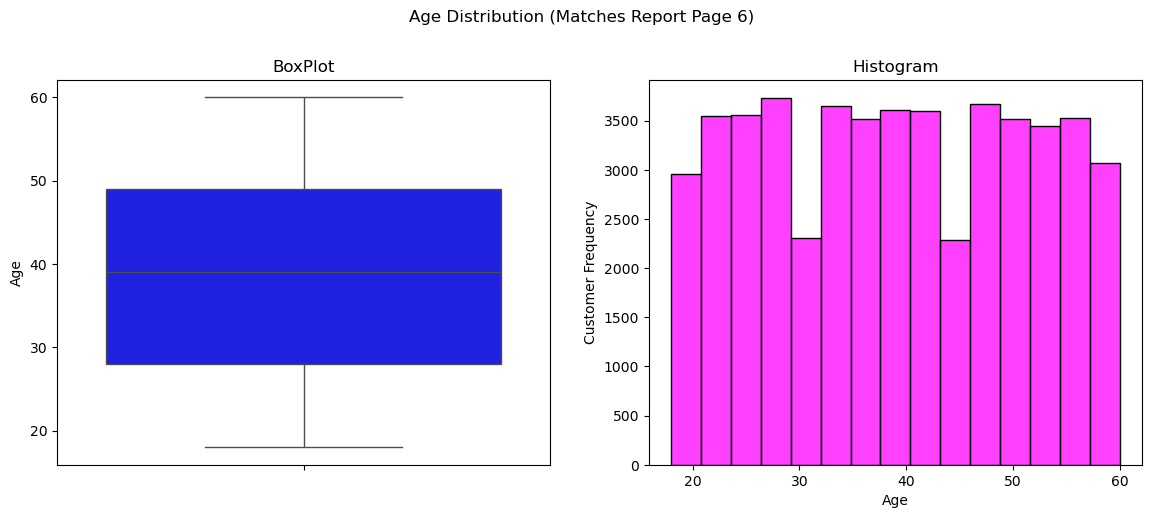


--- Gender Distribution ---
Gender
F    20091
M    29885


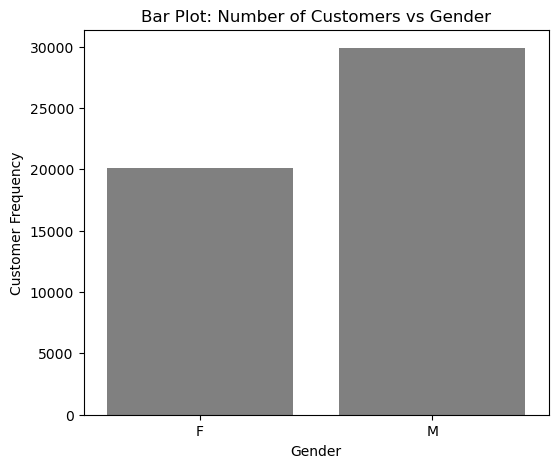


--- Marital Status Distribution ---
Marital_Status
Divorced    11544
Married     27058
Single      11374


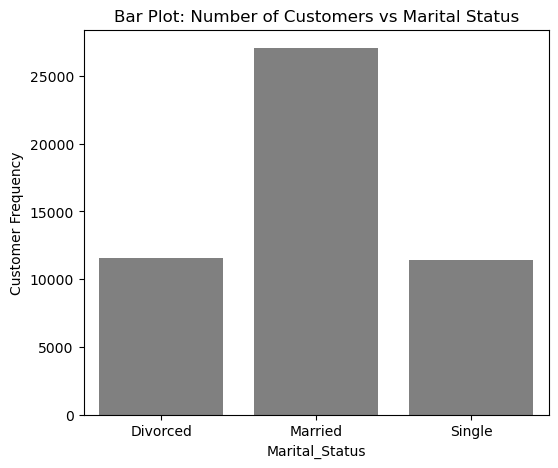


--- Education Distribution ---
Education
BD     14961
LHS     6631
MD     11152
NE      3529
PD      7484
UHS     6219


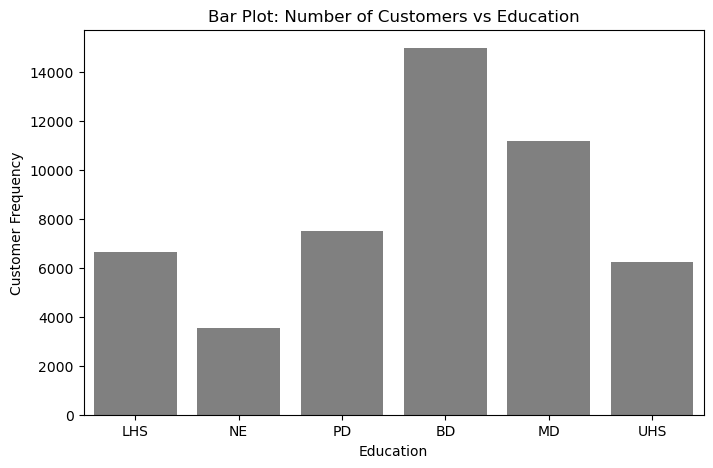


--- Rating Distribution ---
Rating
Cold    23886
Hot     11319
Warm    14771


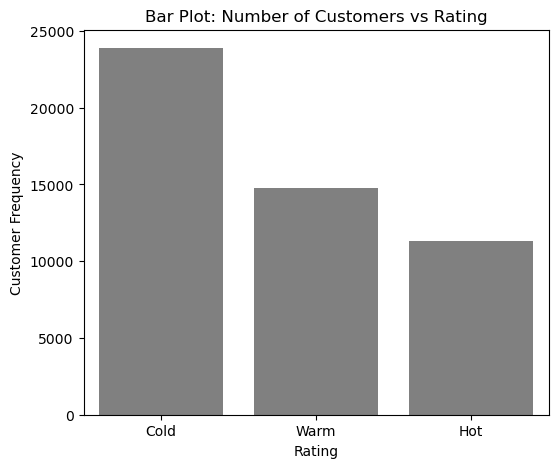

In [89]:
print(" Univariate Analysis Replication")

# --- 2.1 Age Distribution () ---
print("\n--- Age Statistics ---")
print(f"Average Age of Customers is {data['Age'].mean():.0f} years")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Age Distribution (Matches Report Page 6)', y=1.02)

# Box Plot
sns.boxplot(y=data['Age'], ax=axes[0], color='blue')
axes[0].set_title('BoxPlot')
axes[0].set_ylabel('Age')

# Histogram
sns.histplot(data['Age'], bins=15, ax=axes[1], color='magenta', kde=False)
axes[1].set_title('Histogram')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Customer Frequency')
plt.show()

# --- 2.2 Gender Distribution () ---
print("\n--- Gender Distribution ---")
gender_counts = data['Gender'].value_counts().sort_index()
print(gender_counts.to_string())

plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Gender', data=data, color='gray')
plt.title('Bar Plot: Number of Customers vs Gender')
plt.ylabel('Customer Frequency')
plt.show()

# --- 2.3 Marital Status Distribution () ---
print("\n--- Marital Status Distribution ---")
marital_counts = data['Marital_Status'].value_counts().sort_index()
print(marital_counts.to_string())

plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Marital_Status', data=data, color='gray')
plt.title('Bar Plot: Number of Customers vs Marital Status')
plt.ylabel('Customer Frequency')
plt.show()

# --- 2.4 Education Distribution () ---
print("\n--- Education Distribution ---")
edu_counts = data['Education'].value_counts().sort_index()
print(edu_counts.to_string())

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Education', data=data, color='gray')
plt.title('Bar Plot: Number of Customers vs Education')
plt.ylabel('Customer Frequency')
plt.show()

# --- 2.5 Rating Distribution () ---
print("\n--- Rating Distribution ---")
rating_counts = data['Rating'].value_counts().sort_index()
print(rating_counts.to_string())

plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Rating', data=data, color='gray')
plt.title('Bar Plot: Number of Customers vs Rating')
plt.ylabel('Customer Frequency')
plt.show()


In [90]:
# 1. Overall Conversion Rate
total_customers = len(data)
conversion_rate = data['target'].mean() * 100
existing_customers_pct = (data['Current_Product'] == 1).sum() / total_customers * 100
new_customers_pct = (data['Current_Product'] == 0).sum() / total_customers * 100
male_pct = (data['Gender'] == 1).sum() / total_customers * 100
avg_age = data['Age'].mean()

print(f"Overall Conversion Rate (Converted=1): {conversion_rate:.2f}%")
print(f"Existing Customers: {existing_customers_pct:.2f}%")
print(f"New Customers (Targeted): {new_customers_pct:.2f}%")
print(f"Average Age: {avg_age:.2f}")
print(f"Percentage of Male Customers: {male_pct:.2f}%")

Overall Conversion Rate (Converted=1): 38.18%
Existing Customers: 0.00%
New Customers (Targeted): 0.00%
Average Age: 38.98
Percentage of Male Customers: 0.00%


In [91]:
cleaned_data = pd.read_excel(r"C:\Users\Admin\Desktop\DA.BA\Cross_Selling_Project Naresh IT\Insurance_Data_50k.xlsx")


In [92]:
df = cleaned_data.copy()

--- Value Counts for 'Converted' ---
Converted
NotConverted    30897
Converted       19079
Name: count, dtype: int64

--- Percentage of 'Converted' ---
Converted
NotConverted   61.82
Converted      38.18
Name: proportion, dtype: float64


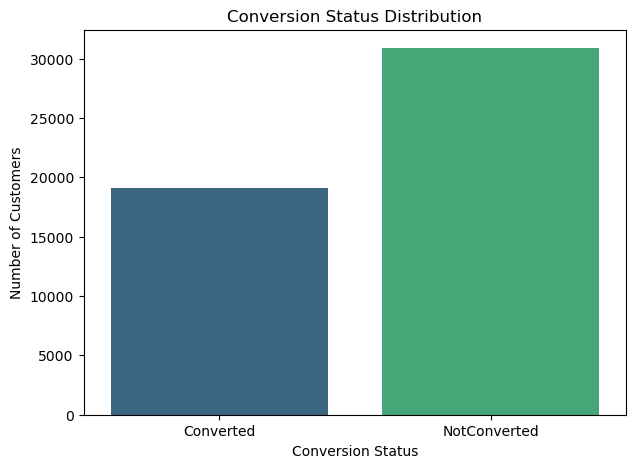

In [93]:
# 1A. Univariate Analysis - Target Variable 'Converted'

# Pandas: Value Counts and Percentage
conversion_counts = df['Converted'].value_counts()
conversion_percentages = df['Converted'].value_counts(normalize=True) * 100

print("--- Value Counts for 'Converted' ---")
print(conversion_counts)
print("\n--- Percentage of 'Converted' ---")
print(conversion_percentages)

# Seaborn/Matplotlib: Bar Plot for visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Converted', data=df, palette='viridis')
plt.title('Conversion Status Distribution')
plt.xlabel('Conversion Status')
plt.ylabel('Number of Customers')
# plt.savefig('converted_univariate_plot.png')
plt.show()

--- Descriptive Statistics for 'Income' ---
count   49951.00
mean        4.97
std         3.29
min         0.89
25%         2.04
50%         3.03
75%         9.11
max        10.12
Name: Income, dtype: float64


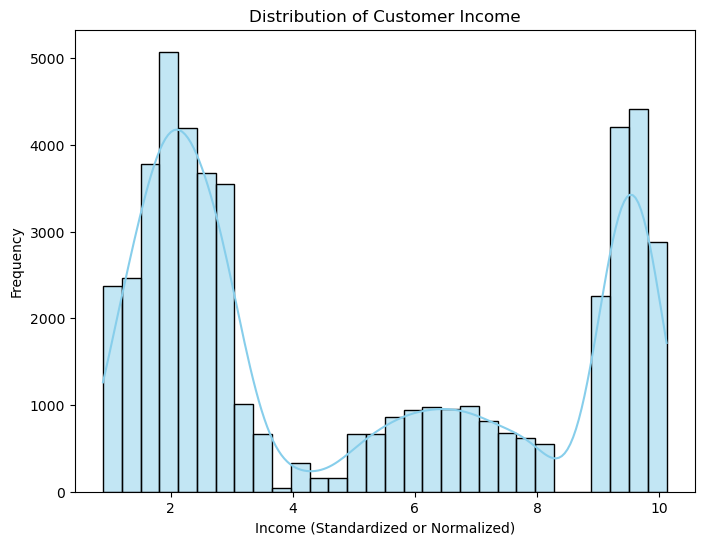

In [94]:
# 1B. Univariate Analysis - Continuous Variable 'Income'

# Pandas: Descriptive Statistics
print("--- Descriptive Statistics for 'Income' ---")
print(df['Income'].describe())

# Seaborn/Matplotlib: Histogram for visualization
plt.figure(figsize=(8, 6))
sns.histplot(df['Income'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Income')
plt.xlabel('Income (Standardized or Normalized)')
plt.ylabel('Frequency')
# plt.savefig('income_univariate_plot.png')
plt.show()

--- Value Counts for 'Rating' ---
Rating
Cold    23876
Warm    14777
Hot     11325
Name: count, dtype: int64

--- Percentage of 'Rating' ---
Rating
Cold   47.77
Warm   29.57
Hot    22.66
Name: proportion, dtype: float64


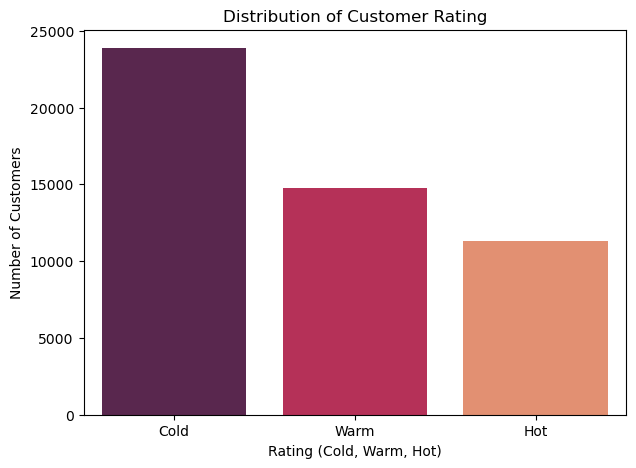

In [95]:
# 1C. Univariate Analysis - Categorical Variable 'Rating'

# Pandas: Value Counts and Percentage
rating_counts = df['Rating'].value_counts()
rating_percentages = df['Rating'].value_counts(normalize=True) * 100

print("--- Value Counts for 'Rating' ---")
print(rating_counts)
print("\n--- Percentage of 'Rating' ---")
print(rating_percentages)

# Seaborn/Matplotlib: Bar Plot for visualization
plt.figure(figsize=(7, 5))
sns.countplot(x='Rating', data=df, order=df['Rating'].value_counts().index, palette='rocket')
plt.title('Distribution of Customer Rating')
plt.xlabel('Rating (Cold, Warm, Hot)')
plt.ylabel('Number of Customers')
# plt.savefig('rating_univariate_plot.png')
plt.show()

--- Conversion Percentage by Customer Rating ---
Converted  Converted  NotConverted
Rating                            
Cold           37.54         62.46
Hot            39.60         60.40
Warm           38.12         61.88


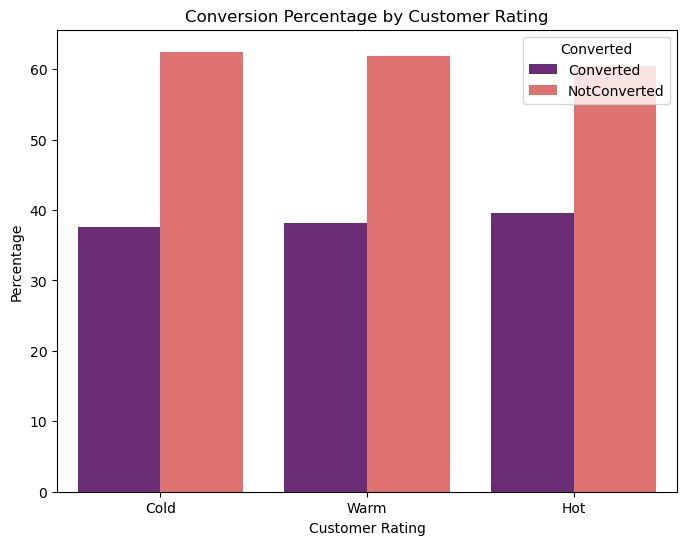

In [96]:
#Bivariate Analysis - Categorical vs. Target: Rating vs. Converted

conversion_rate_by_rating = pd.crosstab(df['Rating'], df['Converted'], normalize='index') * 100

print("--- Conversion Percentage by Customer Rating ---")
print(conversion_rate_by_rating)

# Seaborn/Matplotlib: Stacked Bar Chart for visualization
rating_conversion_df = df.groupby(['Rating', 'Converted']).size().reset_index(name='Count')
total_by_rating = rating_conversion_df.groupby('Rating')['Count'].transform('sum')
rating_conversion_df['Percentage'] = rating_conversion_df['Count'] / total_by_rating * 100

plt.figure(figsize=(8, 6))
sns.barplot(
    x='Rating',
    y='Percentage',
    hue='Converted',
    data=rating_conversion_df,
    order=['Cold', 'Warm', 'Hot'], # Ensure order is logical
    palette='magma'
)
plt.title('Conversion Percentage by Customer Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Percentage')
plt.legend(title='Converted')
# plt.savefig('rating_conversion_bivariate_plot.png')
plt.show()

Look at the 'Converted' column in the crosstab output. You can clearly see the conversion rate for Cold, Warm, and Hot customers. A good rating system should show a clear increase in the conversion rate as the rating moves from 'Cold' $\rightarrow$ 'Warm' $\rightarrow$ 'Hot'.

--- Age Descriptive Statistics Grouped by Conversion Status ---
                count  mean   std   min   25%   50%   75%   max
Converted                                                      
Converted    19070.00 38.96 12.10 18.00 29.00 39.00 49.00 60.00
NotConverted 30884.00 38.99 12.14 18.00 28.00 39.00 50.00 60.00


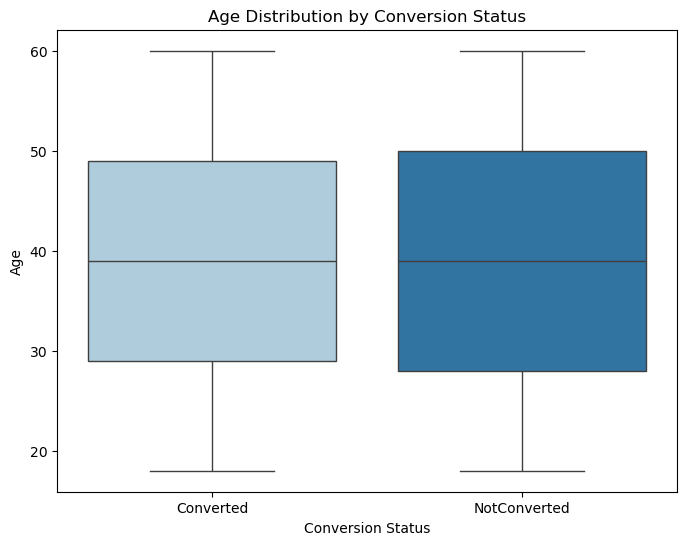

In [97]:
#  Bivariate Analysis - Continuous vs. Target: Age vs. Converted

# Pandas: Grouped Descriptive Statistics
print("--- Age Descriptive Statistics Grouped by Conversion Status ---")
print(df.groupby('Converted')['Age'].describe())

# Seaborn/Matplotlib: Box Plot for visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x='Converted', y='Age', data=df, palette='Paired')
plt.title('Age Distribution by Conversion Status')
plt.xlabel('Conversion Status')
plt.ylabel('Age')
# plt.savefig('age_conversion_bivariate_plot.png')
plt.show()

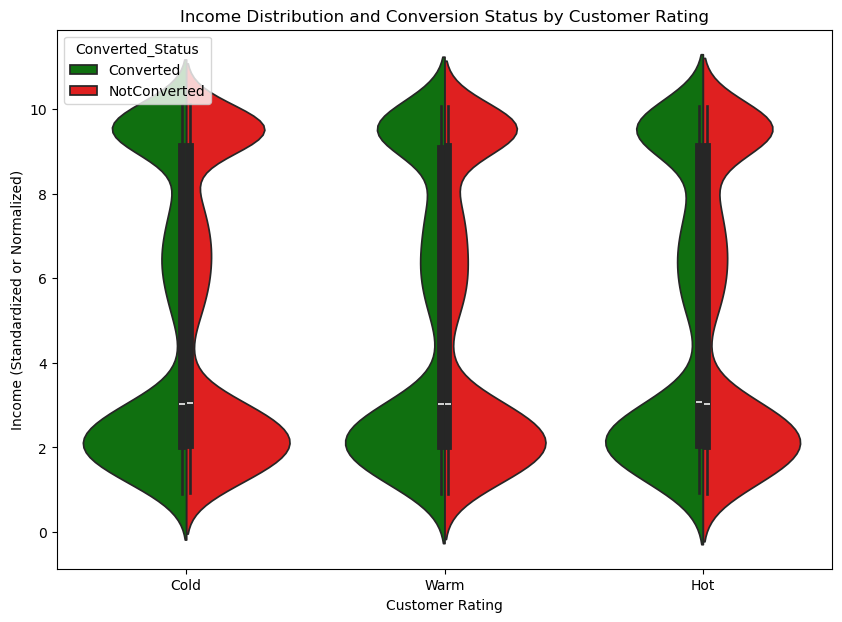

In [98]:
# 3. Multivariate Analysis - Income vs. Converted, grouped by Rating

# Seaborn/Matplotlib: Violin Plot for visualization
plt.figure(figsize=(10, 7))
sns.violinplot(
    x='Rating',
    y='Income',
    hue='Converted',
    data=df,
    order=['Cold', 'Warm', 'Hot'], # Ensure order is logical
    split=True, # Split the violins for better comparison
    palette={'Converted': 'green', 'NotConverted': 'red'}
)
plt.title('Income Distribution and Conversion Status by Customer Rating')
plt.xlabel('Customer Rating')
plt.ylabel('Income (Standardized or Normalized)')
plt.legend(title='Converted_Status')
# plt.savefig('income_rating_conversion_multivariate_plot.png')
plt.show()

--- MEAN INCOME ANALYSIS: TOP EDUCATION AND EXISTING CUSTOMER STATUS ---
                                   count      mean       std       min  \
Education Current_Product target                                         
MD        No              0       3004.0  4.942191  3.305002  0.951087   
                          1       1805.0  4.874538  3.249794  0.931992   
          Yes             0       3861.0  4.915592  3.253387  0.936531   
                          1       2482.0  4.915935  3.273739  0.905561   
PD        No              0       2029.0  5.066222  3.330923  0.930639   
                          1       1231.0  4.884335  3.270860  0.962911   
          Yes             0       2668.0  4.973668  3.295492  0.898252   
                          1       1556.0  4.934187  3.273535  0.916390   

                                       25%       50%       75%        max  
Education Current_Product target                                           
MD        No              0       

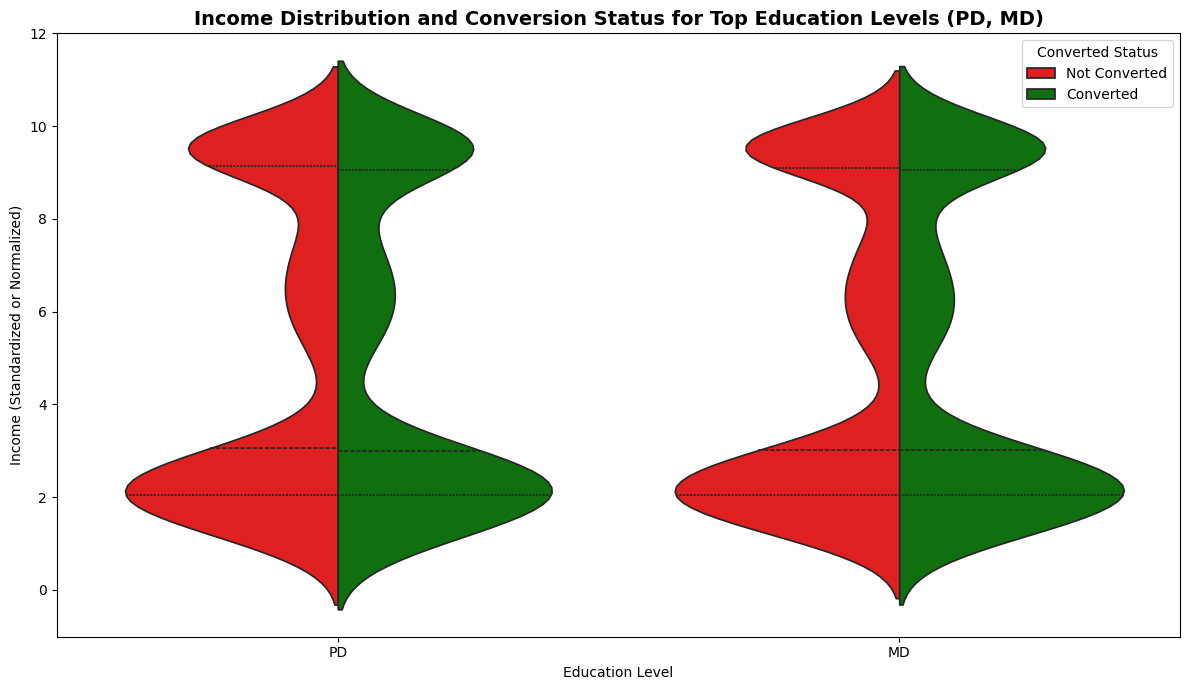

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Show plots inline (important for Jupyter)
%matplotlib inline

# Load dataset
df = pd.read_csv(r"C:\Users\Admin\Desktop\DA.BA\Cross_Selling_Project Naresh IT\cleaned_Insurance_data_50k.csv")

# 1. Focus on top education levels
top_education_levels = ['PD', 'MD']
df_filtered = df[df['Education'].isin(top_education_levels)].copy()

# 2. Mean income grouped by Education, Product, and Target
income_conversion_stats = df_filtered.groupby(['Education', 'Current_Product', 'target'])['Income'].describe()
print("--- MEAN INCOME ANALYSIS: TOP EDUCATION AND EXISTING CUSTOMER STATUS ---")
print(income_conversion_stats)

# 3. Violin plot: Income vs Conversion
plt.figure(figsize=(12, 7))

# Ensure hue labels are consistent
if df_filtered['target'].dtype in ['int64', 'float64']:
    df_filtered['target_label'] = df_filtered['target'].map({0: 'Not Converted', 1: 'Converted'})
else:
    df_filtered['target_label'] = df_filtered['target']

sns.violinplot(
    x='Education',
    y='Income',
    hue='target_label',
    data=df_filtered,
    split=True,
    inner='quartile',  # shows median + quartiles
    palette={'Converted': 'green', 'Not Converted': 'red'},
    order=top_education_levels
)

plt.title('Income Distribution and Conversion Status for Top Education Levels (PD, MD)', fontsize=14, weight='bold')
plt.xlabel('Education Level')
plt.ylabel('Income (Standardized or Normalized)')
plt.legend(title='Converted Status')
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\Admin\Desktop\DA.BA\Cross_Selling_Project Naresh IT\cleaned_Insurance_data_50k.csv"
df = pd.read_csv(file_path)

df.rename(columns = {'target':'Converted'})


,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,Converted
0,30.0,F,Divorced,2.0,LHS,SPT,PG,1.948181,No,NO,-20709.0,INV,2155940.0,Cold,1
1,48.0,M,Divorced,3.0,LHS,SFT,OC,6.372918,No,NO,-52383.0,TLE,991685.0,Warm,1
2,53.0,M,Married,4.0,NE,SPT,PG,5.820387,Yes,NO,4018892.0,ANS,1972325.0,Cold,0
3,45.0,M,Married,2.0,PD,SFT,RR,1.230810,No,ANS,34644.0,ANS,3932434.0,Warm,0
4,37.0,M,Married,3.0,BD,SPT,BA,1.165025,No,NO,27473.0,TLE,1984786.0,Hot,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49971,18.0,M,Single,5.0,BD,SE,FH,3.299525,Yes,TLE,1995596.0,ANS,1029302.0,Cold,0
49972,47.0,M,Married,2.0,UHS,SPT,CB,9.435852,No,ANS,30076.0,PMT,2004517.0,Warm,0
49973,24.0,M,Married,6.0,BD,SPT,FH,2.599383,Yes,ANS,3036540.0,PMT,14938798.0,Warm,0
49974,56.0,F,Divorced,9.0,LHS,SPT,OT,5.041133,Yes,TLE,64384.0,PMT,926561.0,Warm,1


In [3]:
df.head()

,Age,Gender,Marital_Status,Family_Members,Education,Occupation,Job_Title,Income,Current_Product,Current_Product_Type,Current_Coverage,New_Product_Type,New_Coverage,Rating,target
0,30.0,F,Divorced,2.0,LHS,SPT,PG,1.948181,No,NO,-20709.0,INV,2155940.0,Cold,1
1,48.0,M,Divorced,3.0,LHS,SFT,OC,6.372918,No,NO,-52383.0,TLE,991685.0,Warm,1
2,53.0,M,Married,4.0,NE,SPT,PG,5.820387,Yes,NO,4018892.0,ANS,1972325.0,Cold,0
3,45.0,M,Married,2.0,PD,SFT,RR,1.230810,No,ANS,34644.0,ANS,3932434.0,Warm,0
4,37.0,M,Married,3.0,BD,SPT,BA,1.165025,No,NO,27473.0,TLE,1984786.0,Hot,0


In [6]:
df.columns

Index(['Age', 'Gender', 'Marital_Status', 'Family_Members', 'Education',
       'Occupation', 'Job_Title', 'Income', 'Current_Product',
       'Current_Product_Type', 'Current_Coverage', 'New_Product_Type',
       'New_Coverage', 'Rating', 'target'],
      dtype='object')

In [12]:
# --- A. Target Variable: Converted ---
print("--- 1A. Univariate Analysis: Converted Status ---")
conversion_counts = df['target'].value_counts()
conversion_percentages = df['target'].value_counts(normalize=True) * 100

print(conversion_counts)
print("\nPercentage:")
print(conversion_percentages)


--- 1A. Univariate Analysis: Converted Status ---
target
0    30897
1    19079
Name: count, dtype: int64

Percentage:
target
0    61.823675
1    38.176325
Name: proportion, dtype: float64


--- 1A. Univariate Analysis: Converted Status ---


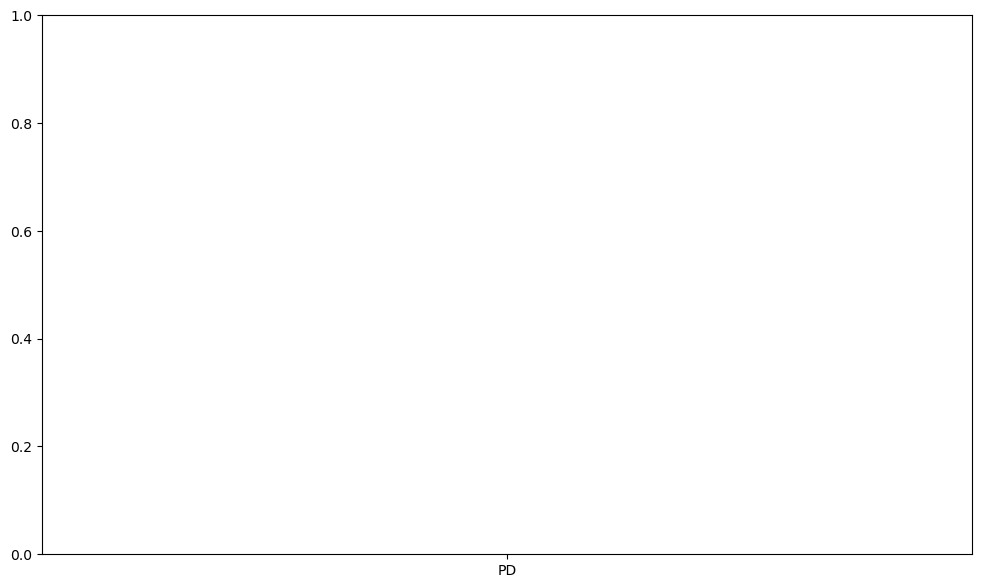

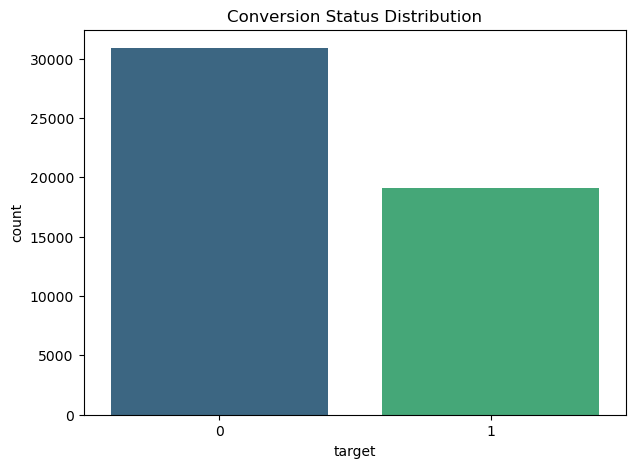


--- 1B. Univariate Analysis: Income ---
count    49976.000000
mean         4.965280
std          3.292877
min          0.893503
25%          2.038755
50%          3.032735
75%          9.106073
max         10.122132
Name: Income, dtype: float64


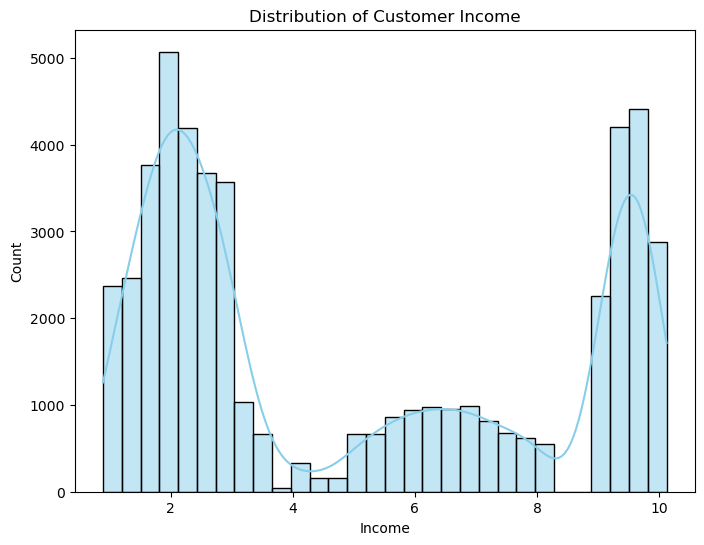


--- 1C. Univariate Analysis: Rating ---
Rating
Cold    23886
Warm    14771
Hot     11319
Name: count, dtype: int64


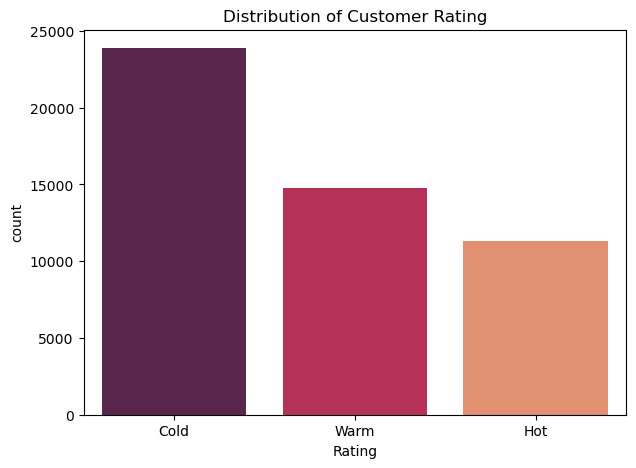

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensures plots appear inline
%matplotlib inline

# --- A. Target Variable: Converted ---
print("--- 1A. Univariate Analysis: Converted Status ---")

plt.figure(figsize=(7, 5))
sns.countplot(x='target', hue='target', data=df, palette='viridis', legend=False)
plt.title('Conversion Status Distribution')
plt.show()

# --- B. Continuous Variable: Income ---
print("\n--- 1B. Univariate Analysis: Income ---")
print(df['Income'].describe())

plt.figure(figsize=(8, 6))
sns.histplot(df['Income'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Income')
plt.show()

# --- C. Categorical Variable: Rating ---
print("\n--- 1C. Univariate Analysis: Rating ---")
print(df['Rating'].value_counts())

plt.figure(figsize=(7, 5))
sns.countplot(
    x='Rating', hue='Rating', data=df,
    order=df['Rating'].value_counts().index,
    palette='rocket', legend=False
)
plt.title('Distribution of Customer Rating')
plt.show()
